In [1]:
# Clone your GitHub repo (you’ll be prompted to authorize if it's private)
!git clone https://github.com/colterwood/LHL-final-final-project.git

Cloning into 'LHL-final-final-project'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 240 (delta 0), reused 12 (delta 0), pack-reused 224 (from 1)
Receiving objects: 100% (240/240), 4.73 MiB | 3.99 MiB/s, done.
Resolving deltas: 100% (115/115), done.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
# load the player game logs CSV from the data folder
df = pd.read_csv("LHL-final-final-project/data/wnba_model_ready_with_top_off_def_players_v2.csv")


# preview
df.head()

,advanced_3par,advanced_ast_pct,advanced_blk_pct,advanced_drtg,advanced_ftr,advanced_ortg,advanced_pace,advanced_pace_by_team_day_of_week,advanced_stl_pct,advanced_trb_pct,...,Nneka Ogwumike,Odyssey Sims,Rebecca Allen,Rhyne Howard,Sabrina Ionescu,Satou Sabally,Stefanie Dolson,Teaira McCowan,Temi Fagbenle,Tina Charles
0,0.254,58.8,22.0,100.4,0.284,114.0,80.7,79.4,9.9,49.3,...,0,0,0,1,0,0,0,0,0,1
1,0.348,77.8,11.6,107.3,0.409,103.6,82.0,80.2,9.8,46.5,...,0,0,0,1,0,0,0,0,0,1
2,0.306,56.7,5.6,100.5,0.306,107.0,77.6,74.8,11.6,50.7,...,0,0,0,1,0,0,0,0,0,1
3,0.324,74.2,3.0,124.6,0.206,107.0,73.8,76.1,12.2,50.8,...,0,0,0,1,0,0,0,0,0,1
4,0.339,73.1,4.3,84.4,0.339,92.0,79.4,79.4,11.3,53.7,...,0,0,0,1,0,0,0,0,0,1


In [4]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    base_model = XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=1.0,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    )
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

,Model,team,opp,team_score,team_score_pred,team_score_mae,opp_score,opp_score_pred,opp_score_mae
0,ATL,ATL,CON,67,78.341866,11.341866,80,87.005692,7.005692
1,ATL,ATL,NYL,75,80.148666,5.148666,81,83.333565,2.333565
2,ATL,ATL,CON,78,82.896729,4.896729,74,74.085495,0.085495
3,ATL,ATL,PHO,72,74.785202,2.785202,63,64.757271,1.757271
4,ATL,ATL,WAS,73,79.218674,6.218674,67,69.289017,2.289017


In [5]:
# example: get importances for 'team_score' and 'opp_score' models
feature_names = X.columns.tolist()

# model.estimators_ is a list: [model_for_team_score, model_for_opp_score]
team_score_model = model.estimators_[0]
opp_score_model = model.estimators_[1]

# get importances
team_score_importances = pd.Series(team_score_model.feature_importances_, index=feature_names)
opp_score_importances = pd.Series(opp_score_model.feature_importances_, index=feature_names)

# sort
team_score_importances = team_score_importances.sort_values(ascending=False)
opp_score_importances = opp_score_importances.sort_values(ascending=False)

In [7]:
# combine into single DataFrame
importances_df = pd.DataFrame({
    "feature": feature_names,
    "team_score_importance": team_score_model.feature_importances_,
    "opp_score_importance": opp_score_model.feature_importances_
})

# sort by average importance descending
importances_df["avg_importance"] = (
    importances_df["team_score_importance"] + importances_df["opp_score_importance"]
) / 2
importances_df = importances_df.sort_values("avg_importance", ascending=False).reset_index(drop=True)

importances_df.head(50)  # or use display(importances_df) in Jupyter

,feature,team_score_importance,opp_score_importance,avg_importance
0,advanced_drtg,0.002195,0.649505,0.325850
1,advanced_ortg,0.587359,0.006180,0.296770
2,team_vs_opp_homeaway_median_score,0.137986,0.031025,0.084506
3,advanced_pace,0.063047,0.077819,0.070433
4,opponent_fg_pct,0.003938,0.035853,0.019895
5,advanced_ts_pct,0.031042,0.001921,0.016481
6,advanced_stl_pct,0.020868,0.010768,0.015818
7,team_day_median_allowed,0.017888,0.011825,0.014857
8,team_vs_opp_median_score,0.017129,0.011145,0.014137
9,Odyssey Sims,0.001797,0.022988,0.012393


In [8]:
# keep features where either importance is >= 0.001
keep_features = importances_df[
    (importances_df["team_score_importance"] >= 0.001) |
    (importances_df["opp_score_importance"] >= 0.001)
]["feature"].tolist()

In [9]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    X = X[keep_features]
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    base_model = XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=1.0,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    )
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

,Model,team,opp,team_score,team_score_pred,team_score_mae,opp_score,opp_score_pred,opp_score_mae
0,ATL,ATL,CON,67,77.887100,10.887100,80,86.830307,6.830307
1,ATL,ATL,NYL,75,79.389717,4.389717,81,83.692833,2.692833
2,ATL,ATL,CON,78,82.106773,4.106773,74,74.294403,0.294403
3,ATL,ATL,PHO,72,71.433167,0.566833,63,64.029411,1.029411
4,ATL,ATL,WAS,73,77.812012,4.812012,67,68.659927,1.659927


In [10]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,0.566833,10.887100,4.435932,4.248245,0.294403,7.001907,3.352740,2.485939
1,CHI,0.790184,7.791901,3.216453,2.690166,0.884514,7.065704,3.377739,3.200211
2,CON,0.030823,7.753197,4.053193,4.729279,0.763016,9.158134,4.603868,4.720654
3,DAL,0.770798,3.683128,2.331429,2.431606,0.812019,6.350403,2.770631,2.382832
4,IND,0.271027,6.975204,2.226648,1.615017,0.254807,7.805260,2.783409,1.776398
5,LAS,0.689148,11.072189,3.746829,2.092140,0.057770,15.336128,4.115891,2.354664
6,LVA,0.110825,9.318069,3.536216,3.223713,0.190536,7.807869,3.423549,3.081211
7,League,0.003761,18.340836,1.679920,0.848591,0.013992,19.004883,1.527835,0.923203
8,MIN,0.145767,9.045143,3.482954,2.338200,0.087006,9.714752,3.089969,2.472492
9,NYL,0.820511,4.764969,2.260571,1.214306,0.468803,3.345032,1.770432,1.540405


In [11]:
# example: get importances for 'team_score' and 'opp_score' models
feature_names = X.columns.tolist()

# model.estimators_ is a list: [model_for_team_score, model_for_opp_score]
team_score_model = model.estimators_[0]
opp_score_model = model.estimators_[1]

# get importances
team_score_importances = pd.Series(team_score_model.feature_importances_, index=feature_names)
opp_score_importances = pd.Series(opp_score_model.feature_importances_, index=feature_names)

# sort
team_score_importances = team_score_importances.sort_values(ascending=False)
opp_score_importances = opp_score_importances.sort_values(ascending=False)

In [12]:
# combine into single DataFrame
importances_df = pd.DataFrame({
    "feature": feature_names,
    "team_score_importance": team_score_model.feature_importances_,
    "opp_score_importance": opp_score_model.feature_importances_
})

# sort by average importance descending
importances_df["avg_importance"] = (
    importances_df["team_score_importance"] + importances_df["opp_score_importance"]
) / 2
importances_df = importances_df.sort_values("avg_importance", ascending=False).reset_index(drop=True)

importances_df.head(50)  # or use display(importances_df) in Jupyter

,feature,team_score_importance,opp_score_importance,avg_importance
0,advanced_ortg,0.588675,0.005998,0.297337
1,advanced_drtg,0.001891,0.586854,0.294372
2,advanced_pace,0.072161,0.095154,0.083657
3,team_vs_opp_homeaway_median_score,0.112379,0.031717,0.072048
4,advanced_stl_pct,0.027589,0.015889,0.021739
5,opponent_fg_pct,0.004478,0.034540,0.019509
6,team_vs_opp_median_score,0.019481,0.017515,0.018498
7,advanced_ts_pct,0.031401,0.002551,0.016976
8,Breanna Stewart,0.030715,0.000469,0.015592
9,defensive_four_factors_efg_pct,0.009173,0.017512,0.013342


In [13]:
keep_features = importances_df[
    (importances_df["team_score_importance"] >= 0.01) |
    (importances_df["opp_score_importance"] >= 0.01)
]["feature"].tolist()

In [14]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    X = X[keep_features]
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    base_model = XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=1.0,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    )
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

,Model,team,opp,team_score,team_score_pred,team_score_mae,opp_score,opp_score_pred,opp_score_mae
0,ATL,ATL,CON,67,77.925575,10.925575,80,85.480171,5.480171
1,ATL,ATL,NYL,75,78.688728,3.688728,81,82.709084,1.709084
2,ATL,ATL,CON,78,81.389290,3.389290,74,73.126534,0.873466
3,ATL,ATL,PHO,72,70.418106,1.581894,63,64.195381,1.195381
4,ATL,ATL,WAS,73,79.577477,6.577477,67,70.017715,3.017715


In [15]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,1.356323,10.925575,4.270839,3.539009,0.873466,5.562164,3.069076,2.363400
1,CHI,0.122101,8.132484,3.004596,2.574768,0.419518,6.259003,3.008218,2.905975
2,CON,0.449249,7.071236,3.771657,3.575886,1.305679,9.104210,4.682408,4.033775
3,DAL,0.808060,3.417862,1.689024,1.320229,0.036285,5.811745,2.810522,3.409748
4,IND,0.183289,7.519508,2.504124,1.193844,0.374184,6.436699,2.693111,1.974075
5,LAS,0.184258,11.036682,3.508990,3.366680,1.174606,10.818905,4.205168,2.416908
6,LVA,0.241447,9.486900,3.500658,2.766079,0.310471,5.274925,2.583759,2.498505
7,League,0.002319,19.595566,1.685170,0.793278,0.008835,18.667290,1.503342,0.868786
8,MIN,1.030334,7.660980,4.483956,3.343800,0.548553,8.467285,3.427751,2.886253
9,NYL,0.467659,4.434189,2.280481,1.747986,0.321037,2.309784,1.142860,1.038055


In [16]:
# example: get importances for 'team_score' and 'opp_score' models
feature_names = X.columns.tolist()

# model.estimators_ is a list: [model_for_team_score, model_for_opp_score]
team_score_model = model.estimators_[0]
opp_score_model = model.estimators_[1]

# get importances
team_score_importances = pd.Series(team_score_model.feature_importances_, index=feature_names)
opp_score_importances = pd.Series(opp_score_model.feature_importances_, index=feature_names)

# sort
team_score_importances = team_score_importances.sort_values(ascending=False)
opp_score_importances = opp_score_importances.sort_values(ascending=False)

In [17]:
# combine into single DataFrame
importances_df = pd.DataFrame({
    "feature": feature_names,
    "team_score_importance": team_score_model.feature_importances_,
    "opp_score_importance": opp_score_model.feature_importances_
})

# sort by average importance descending
importances_df["avg_importance"] = (
    importances_df["team_score_importance"] + importances_df["opp_score_importance"]
) / 2
importances_df = importances_df.sort_values("avg_importance", ascending=False).reset_index(drop=True)

importances_df.head(50)  # or use display(importances_df) in Jupyter

,feature,team_score_importance,opp_score_importance,avg_importance
0,advanced_drtg,0.004732,0.741699,0.373215
1,advanced_ortg,0.627563,0.004999,0.316281
2,advanced_pace,0.094242,0.097249,0.095746
3,team_vs_opp_homeaway_median_score,0.129883,0.025742,0.077812
4,advanced_stl_pct,0.029584,0.015626,0.022605
5,advanced_ts_pct,0.033540,0.003515,0.018528
6,opponent_fg_pct,0.005668,0.029718,0.017693
7,team_vs_opp_median_score,0.019334,0.011358,0.015346
8,defensive_four_factors_efg_pct,0.007188,0.017817,0.012502
9,advanced_pace_by_team_day_of_week,0.009771,0.012033,0.010902


In [18]:
keep_features = importances_df[
    (importances_df["avg_importance"] >= 0.01)
]["feature"].tolist()

In [19]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    X = X[keep_features]
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    base_model = XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=1.0,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    )
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

,Model,team,opp,team_score,team_score_pred,team_score_mae,opp_score,opp_score_pred,opp_score_mae
0,ATL,ATL,CON,67,78.008629,11.008629,80,85.944511,5.944511
1,ATL,ATL,NYL,75,78.375366,3.375366,81,83.253792,2.253792
2,ATL,ATL,CON,78,81.007805,3.007805,74,72.764122,1.235878
3,ATL,ATL,PHO,72,69.524338,2.475662,63,62.435349,0.564651
4,ATL,ATL,WAS,73,78.079704,5.079704,67,68.605072,1.605072


In [20]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,0.707664,11.008629,3.932604,3.191586,0.564651,5.944511,3.004591,1.929432
1,CHI,0.558395,8.659966,3.321517,3.109245,0.095589,5.286140,1.956123,1.665733
2,CON,0.676537,7.832047,3.748112,3.489260,1.087906,7.481812,3.984873,3.629532
3,DAL,0.540092,3.708603,1.543978,1.296902,0.451309,3.140060,2.161268,2.368935
4,IND,0.135559,7.365540,2.528420,1.223457,0.309494,6.754425,2.776628,1.771759
5,LAS,0.047630,10.205772,3.150324,1.975639,0.380821,14.678448,3.730368,2.130768
6,LVA,0.814972,9.513885,3.793880,3.317730,0.291641,4.906219,2.516418,2.601349
7,League,0.008537,19.326653,1.644903,0.846447,0.016663,18.788490,1.461494,0.704079
8,MIN,0.198410,9.895164,4.169523,3.805820,0.564583,9.105011,3.440903,2.966240
9,NYL,0.316086,4.771690,1.887536,0.804920,0.018242,3.207047,1.144443,0.961674


In [21]:
depth_results = []

for max_depth in range(2, 11):  # test depths from 2 to 10
    model = MultiOutputRegressor(XGBRegressor(
        n_estimators=300,
        max_depth=max_depth,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=1.0,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    ))

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    team_mae = mean_absolute_error(y_test.iloc[:, 0], y_pred[:, 0])
    opp_mae = mean_absolute_error(y_test.iloc[:, 1], y_pred[:, 1])
    avg_mae = (team_mae + opp_mae) / 2

    depth_results.append({
        "max_depth": max_depth,
        "team_score_mae": team_mae,
        "opp_score_mae": opp_mae,
        "avg_mae": avg_mae
    })

depth_df = pd.DataFrame(depth_results)

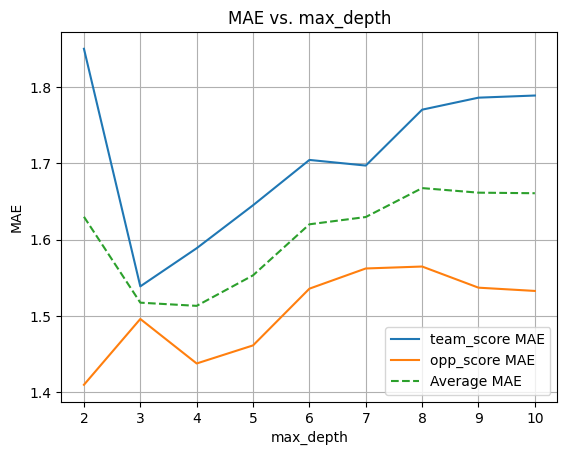

In [22]:
plt.plot(depth_df["max_depth"], depth_df["team_score_mae"], label="team_score MAE")
plt.plot(depth_df["max_depth"], depth_df["opp_score_mae"], label="opp_score MAE")
plt.plot(depth_df["max_depth"], depth_df["avg_mae"], label="Average MAE", linestyle="--")
plt.xlabel("max_depth")
plt.ylabel("MAE")
plt.title("MAE vs. max_depth")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    X = X[keep_features]
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    base_model = XGBRegressor(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=1.0,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    )
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

,Model,team,opp,team_score,team_score_pred,team_score_mae,opp_score,opp_score_pred,opp_score_mae
0,ATL,ATL,CON,67,76.720619,9.720619,80,86.525749,6.525749
1,ATL,ATL,NYL,75,77.376175,2.376175,81,82.473953,1.473953
2,ATL,ATL,CON,78,80.157211,2.157211,74,73.319427,0.680573
3,ATL,ATL,PHO,72,69.655632,2.344368,63,63.426105,0.426105
4,ATL,ATL,WAS,73,76.429909,3.429909,67,69.608871,2.608871


In [24]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,0.163582,9.720619,3.141862,2.360271,0.426105,6.525749,2.792869,2.041412
1,CHI,0.788116,9.196556,3.697831,3.186932,0.150482,4.582634,2.028024,1.575100
2,CON,0.254852,8.480606,3.299742,3.413277,0.706467,7.719963,3.905054,3.185272
3,DAL,0.813499,3.513565,2.170426,2.196892,0.574753,4.336784,2.490502,2.493874
4,IND,0.100151,6.440971,2.535541,1.623035,0.136101,6.135094,2.278798,1.448639
5,LAS,0.484604,11.117783,3.114411,2.128830,0.661133,12.640335,3.582897,2.010704
6,LVA,0.252861,9.045364,3.349030,2.413361,0.805290,4.515015,2.421411,2.377468
7,League,0.011642,16.540421,1.538753,0.856274,0.053940,17.325691,1.496100,0.964512
8,MIN,0.569153,7.363075,3.876899,3.194374,0.349136,8.532982,3.246042,2.298767
9,NYL,0.192047,4.713387,1.637137,0.804775,0.225922,2.240646,0.934381,0.867336


In [25]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    X = X[keep_features]
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    base_model = XGBRegressor(
        n_estimators=500,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=1.0,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    )
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

,Model,team,opp,team_score,team_score_pred,team_score_mae,opp_score,opp_score_pred,opp_score_mae
0,ATL,ATL,CON,67,76.705452,9.705452,80,86.525093,6.525093
1,ATL,ATL,NYL,75,77.338654,2.338654,81,82.455498,1.455498
2,ATL,ATL,CON,78,80.178177,2.178177,74,73.346390,0.653610
3,ATL,ATL,PHO,72,69.659592,2.340408,63,63.371555,0.371555
4,ATL,ATL,WAS,73,76.457123,3.457123,67,69.597832,2.597832


In [26]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,0.146034,9.705452,3.136040,2.339531,0.371555,6.525093,2.775033,2.026665
1,CHI,0.783379,9.196281,3.699562,3.193077,0.153625,4.565048,2.029938,1.575367
2,CON,0.240158,8.480576,3.299777,3.414108,0.714523,7.708076,3.908471,3.183918
3,DAL,0.812119,3.487961,2.157961,2.202930,0.603424,4.322327,2.487241,2.489140
4,IND,0.061287,6.423981,2.537813,1.630558,0.125580,6.136017,2.275359,1.433983
5,LAS,0.494370,11.137238,3.115792,2.127636,0.671600,12.625019,3.577568,1.985973
6,LVA,0.210587,9.066597,3.346870,2.424355,0.797386,4.505829,2.420514,2.379272
7,League,0.012321,16.461449,1.487271,0.815969,0.005150,17.240868,1.495939,0.930721
8,MIN,0.566483,7.366722,3.871403,3.188290,0.350975,8.529984,3.248553,2.305492
9,NYL,0.185829,4.725220,1.637190,0.802258,0.222351,2.242119,0.934629,0.871475


In [27]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    X = X[keep_features]
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    base_model = XGBRegressor(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=1.0,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    )
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

,Model,team,opp,team_score,team_score_pred,team_score_mae,opp_score,opp_score_pred,opp_score_mae
0,ATL,ATL,CON,67,76.787537,9.787537,80,86.550117,6.550117
1,ATL,ATL,NYL,75,77.398407,2.398407,81,82.513245,1.513245
2,ATL,ATL,CON,78,80.213181,2.213181,74,73.297012,0.702988
3,ATL,ATL,PHO,72,69.728279,2.271721,63,63.572052,0.572052
4,ATL,ATL,WAS,73,76.526154,3.526154,67,69.683792,2.683792


In [28]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,0.144424,9.787537,3.169732,2.335064,0.572052,6.550117,2.832445,2.098518
1,CHI,0.786797,9.229073,3.694454,3.190022,0.138199,4.693855,2.051328,1.624485
2,CON,0.274681,8.568848,3.281244,3.417023,0.694580,7.685371,3.887310,3.195061
3,DAL,0.857979,3.621239,2.209330,2.178879,0.616730,4.395950,2.512872,2.473316
4,IND,0.206017,6.550797,2.540280,1.636318,0.117058,6.127434,2.282658,1.507877
5,LAS,0.480278,11.131294,3.132122,2.111248,0.629730,12.578999,3.581554,1.977322
6,LVA,0.356583,9.017693,3.367106,2.392303,0.802605,4.534828,2.433758,2.367531
7,League,0.015373,16.846031,1.580109,0.982620,0.001411,17.377350,1.477537,0.962570
8,MIN,0.565498,7.377403,3.886896,3.217354,0.369576,8.565575,3.246531,2.282764
9,NYL,0.243729,4.713394,1.630759,0.785103,0.276627,2.193756,0.925855,0.868446


In [29]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    X = X[keep_features]
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    base_model = XGBRegressor(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=1.0,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    )
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

,Model,team,opp,team_score,team_score_pred,team_score_mae,opp_score,opp_score_pred,opp_score_mae
0,ATL,ATL,CON,67,77.625549,10.625549,80,85.914894,5.914894
1,ATL,ATL,NYL,75,78.339188,3.339188,81,83.003799,2.003799
2,ATL,ATL,CON,78,80.686859,2.686859,74,73.348038,0.651962
3,ATL,ATL,PHO,72,70.641212,1.358788,63,68.215218,5.215218
4,ATL,ATL,WAS,73,76.585258,3.585258,67,74.483467,7.483467


In [30]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,0.522560,10.625549,3.147378,2.456770,0.651962,7.483467,4.154307,4.694195
1,CHI,0.123436,8.492462,3.558224,3.344807,0.361015,6.399925,2.770972,2.561001
2,CON,0.514526,9.010429,3.840316,3.517223,0.123848,8.165230,4.033501,3.691853
3,DAL,0.101624,1.831345,1.183908,1.264702,0.209175,4.001175,2.143663,2.121033
4,IND,0.083786,8.103256,2.362052,1.364388,0.381035,7.615807,2.952312,2.455910
5,LAS,0.014046,10.552277,3.507552,2.519260,0.005928,8.619072,3.045569,2.320885
6,LVA,0.456398,8.843719,3.640347,3.226925,0.277206,6.114655,3.293652,3.045280
7,League,0.049850,17.896118,2.098649,1.248562,0.019554,19.540909,1.902981,1.168964
8,MIN,0.342422,9.521866,4.123225,3.863083,0.374275,9.586967,3.294991,2.152466
9,NYL,0.052078,3.641800,1.616182,1.270245,0.221596,1.884377,1.084806,1.209541


In [31]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    X = X[keep_features]
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    base_model = XGBRegressor(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=1.0,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    )
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

,Model,team,opp,team_score,team_score_pred,team_score_mae,opp_score,opp_score_pred,opp_score_mae
0,ATL,ATL,CON,67,76.993439,9.993439,80,86.293716,6.293716
1,ATL,ATL,NYL,75,77.327934,2.327934,81,83.926880,2.926880
2,ATL,ATL,CON,78,80.764114,2.764114,74,73.473663,0.526337
3,ATL,ATL,PHO,72,69.914482,2.085518,63,62.396748,0.603252
4,ATL,ATL,WAS,73,75.174492,2.174492,67,69.078262,2.078262


In [32]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,1.202583,9.993439,3.156501,2.251213,0.526337,7.510612,3.320906,2.502571
1,CHI,0.833748,10.559326,4.164619,3.420773,0.177109,4.334862,2.045219,1.937511
2,CON,0.320465,8.371857,3.318913,3.022831,0.567451,7.944641,4.084943,3.471992
3,DAL,0.211853,3.806992,2.047602,2.014744,0.905098,4.691902,2.629887,2.972458
4,IND,0.236168,6.617661,2.382144,1.005730,0.938301,5.779160,2.526261,1.632381
5,LAS,0.181694,9.863304,2.923940,1.891575,0.811821,13.534824,3.574975,1.613724
6,LVA,0.129448,8.529968,2.942097,2.659588,0.524315,4.001587,2.249711,2.263500
7,League,0.029800,17.158936,1.645968,0.971825,0.029331,16.630920,1.466221,0.880623
8,MIN,0.191750,6.936234,3.334236,2.427345,0.923424,8.127434,3.455820,3.213249
9,NYL,0.522034,4.713020,2.026335,1.402946,0.199989,3.255280,1.333714,1.234470


In [33]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    X = X[keep_features]
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    base_model = XGBRegressor(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.07,
        subsample=0.8,
        colsample_bytree=1.0,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    )
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

,Model,team,opp,team_score,team_score_pred,team_score_mae,opp_score,opp_score_pred,opp_score_mae
0,ATL,ATL,CON,67,76.692818,9.692818,80,86.001480,6.001480
1,ATL,ATL,NYL,75,77.669418,2.669418,81,83.152046,2.152046
2,ATL,ATL,CON,78,80.433472,2.433472,74,72.980057,1.019943
3,ATL,ATL,PHO,72,71.237541,0.762459,63,62.630871,0.369129
4,ATL,ATL,WAS,73,76.595276,3.595276,67,68.957962,1.957962


In [34]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,0.456039,9.692818,2.978699,2.551445,0.369129,6.280159,3.096989,2.055004
1,CHI,1.315468,9.250427,3.932319,3.394421,0.130898,4.920303,2.160544,1.988834
2,CON,0.144234,7.762566,3.431492,3.834743,0.795891,8.054985,3.981143,2.952099
3,DAL,0.413063,3.583557,1.967939,2.129620,0.131401,4.088585,2.189039,2.580284
4,IND,0.046989,6.525642,2.305317,1.269970,0.676582,6.971176,2.658968,1.917267
5,LAS,0.026573,10.775780,2.985364,2.151699,0.581917,12.617584,3.563471,1.772644
6,LVA,0.094955,9.089714,3.256107,2.766777,0.518005,4.649063,2.359091,2.257381
7,League,0.027672,16.925583,1.600495,0.949852,0.000900,17.465065,1.470683,0.814564
8,MIN,0.298325,6.815460,3.515024,2.718849,0.329010,8.508415,3.392412,2.721500
9,NYL,0.463524,5.348114,1.869148,1.061718,0.045334,2.106216,0.780971,0.669708


In [35]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    X = X[keep_features]
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    base_model = XGBRegressor(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.05,
        subsample=1,
        colsample_bytree=1.0,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    )
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

,Model,team,opp,team_score,team_score_pred,team_score_mae,opp_score,opp_score_pred,opp_score_mae
0,ATL,ATL,CON,67,77.350693,10.350693,80,85.825768,5.825768
1,ATL,ATL,NYL,75,77.789436,2.789436,81,82.285690,1.285690
2,ATL,ATL,CON,78,82.271744,4.271744,74,73.274498,0.725502
3,ATL,ATL,PHO,72,71.369240,0.630760,63,62.476933,0.523067
4,ATL,ATL,WAS,73,77.497116,4.497116,67,70.041481,3.041481


In [36]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,0.630760,10.350693,3.698168,3.530590,0.523067,6.140831,2.986266,2.163586
1,CHI,0.973366,7.553375,3.203985,3.169937,0.519936,5.404587,2.514754,2.242680
2,CON,0.439056,9.588448,3.515821,3.130188,0.657372,7.967255,3.896946,2.514885
3,DAL,1.178917,3.881210,2.395256,2.558456,0.317619,3.680222,1.924293,2.167336
4,IND,0.363510,8.794365,3.250967,2.288597,0.643570,5.985832,3.113662,2.979733
5,LAS,0.631767,12.343636,3.967337,2.276958,0.822762,11.727703,3.917580,2.455383
6,LVA,0.216644,8.491692,3.792587,3.525566,0.992645,4.908691,2.603817,2.192669
7,League,0.002220,15.337738,1.701142,1.197536,0.004494,18.519470,1.567449,1.006664
8,MIN,0.290405,9.237968,4.342648,3.455654,0.805527,7.335632,3.767337,3.614132
9,NYL,1.091713,6.527199,3.067953,2.050377,0.201477,2.705185,1.062901,0.947620


In [37]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    X = X[keep_features]
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    base_model = XGBRegressor(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.6,
        colsample_bytree=1.0,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    )
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

,Model,team,opp,team_score,team_score_pred,team_score_mae,opp_score,opp_score_pred,opp_score_mae
0,ATL,ATL,CON,67,75.729584,8.729584,80,85.646324,5.646324
1,ATL,ATL,NYL,75,77.094223,2.094223,81,82.633720,1.633720
2,ATL,ATL,CON,78,80.816307,2.816307,74,75.158539,1.158539
3,ATL,ATL,PHO,72,70.071014,1.928986,63,62.707546,0.292454
4,ATL,ATL,WAS,73,74.479912,1.479912,67,68.493591,1.493591


In [38]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,0.877686,8.729584,2.642242,1.796146,0.292454,6.071228,2.911625,1.638210
1,CHI,0.537834,8.867416,4.214855,3.865747,0.605774,3.854622,2.106250,1.713924
2,CON,0.347298,7.692879,3.349375,3.131783,0.168777,8.247307,3.882442,3.615631
3,DAL,0.692558,5.223457,2.712335,2.455753,0.158691,5.662041,3.174424,3.214390
4,IND,0.047203,6.864388,2.565562,1.862904,0.236786,4.734535,1.923053,1.392368
5,LAS,0.223930,8.845230,3.210879,2.424099,0.511276,13.508579,3.670255,2.127678
6,LVA,0.028694,7.742767,2.920901,2.285744,0.076660,3.672981,2.448802,3.106606
7,League,0.038445,16.333870,1.682141,0.961155,0.002350,17.968925,1.415346,0.853275
8,MIN,0.013008,6.895302,2.996073,2.172958,0.346218,9.481743,3.084322,2.387264
9,NYL,0.076797,4.148476,1.244227,0.900318,0.177414,3.081963,1.340719,1.111069


In [39]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    X = X[keep_features]
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    base_model = XGBRegressor(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    )
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

,Model,team,opp,team_score,team_score_pred,team_score_mae,opp_score,opp_score_pred,opp_score_mae
0,ATL,ATL,CON,67,76.085541,9.085541,80,85.197151,5.197151
1,ATL,ATL,NYL,75,77.370285,2.370285,81,82.510735,1.510735
2,ATL,ATL,CON,78,80.080719,2.080719,74,73.059273,0.940727
3,ATL,ATL,PHO,72,69.986053,2.013947,63,64.340172,1.340172
4,ATL,ATL,WAS,73,74.773918,1.773918,67,70.367355,3.367355


In [40]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,1.041740,9.085541,2.728024,2.047333,0.940727,6.027962,3.035602,2.439045
1,CHI,0.651825,10.459404,4.728401,4.236561,0.120087,4.548431,2.096628,1.598953
2,CON,0.079895,7.017746,3.380546,4.369736,0.900986,7.694229,3.973426,3.631931
3,DAL,0.549553,4.922798,2.345920,2.528320,0.313095,3.775253,2.158454,2.640713
4,IND,0.155678,7.031036,2.420040,1.526169,0.492119,6.656227,2.741293,1.926689
5,LAS,0.000877,12.313423,3.497873,1.785625,0.798630,12.025620,3.377258,2.068768
6,LVA,0.147453,9.217072,3.318150,2.758549,0.032310,4.376579,2.463460,2.696571
7,League,0.029877,16.185661,1.865758,1.300068,0.003784,18.204659,1.512099,0.867453
8,MIN,0.478790,7.222565,3.448484,2.616325,0.335831,7.985229,3.100969,2.461544
9,NYL,0.142731,3.507805,1.618804,1.275646,0.107811,1.564484,0.607378,0.522354


In [41]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    X = X[keep_features]
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    base_model = XGBRegressor(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=1,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    )
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

,Model,team,opp,team_score,team_score_pred,team_score_mae,opp_score,opp_score_pred,opp_score_mae
0,ATL,ATL,CON,67,76.720619,9.720619,80,86.525749,6.525749
1,ATL,ATL,NYL,75,77.376175,2.376175,81,82.473953,1.473953
2,ATL,ATL,CON,78,80.157211,2.157211,74,73.319427,0.680573
3,ATL,ATL,PHO,72,69.655632,2.344368,63,63.426105,0.426105
4,ATL,ATL,WAS,73,76.429909,3.429909,67,69.608871,2.608871


In [42]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

,Model,team_score_mae_min,team_score_mae_max,team_score_mae_mean,team_score_mae_median,opp_score_mae_min,opp_score_mae_max,opp_score_mae_mean,opp_score_mae_median
0,ATL,0.163582,9.720619,3.141862,2.360271,0.426105,6.525749,2.792869,2.041412
1,CHI,0.788116,9.196556,3.697831,3.186932,0.150482,4.582634,2.028024,1.575100
2,CON,0.254852,8.480606,3.299742,3.413277,0.706467,7.719963,3.905054,3.185272
3,DAL,0.813499,3.513565,2.170426,2.196892,0.574753,4.336784,2.490502,2.493874
4,IND,0.100151,6.440971,2.535541,1.623035,0.136101,6.135094,2.278798,1.448639
5,LAS,0.484604,11.117783,3.114411,2.128830,0.661133,12.640335,3.582897,2.010704
6,LVA,0.252861,9.045364,3.349030,2.413361,0.805290,4.515015,2.421411,2.377468
7,League,0.011642,16.540421,1.538753,0.856274,0.053940,17.325691,1.496100,0.964512
8,MIN,0.569153,7.363075,3.876899,3.194374,0.349136,8.532982,3.246042,2.298767
9,NYL,0.192047,4.713387,1.637137,0.804775,0.225922,2.240646,0.934381,0.867336


In [43]:
import joblib

# Save to file
joblib.dump(model, "xgboost_wnba_model.pkl")

predictions_df.to_csv("wnba_predictions.csv", index=False)

mae_summary.to_csv("wnba_mae_summary.csv", index=False)

config = {
    "model_type": "XGBoost",
    "n_estimators": 300,
    "max_depth": 3,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 1.0,
    "min_child_weight": 1,
    "random_state": 42
}

import json
with open("wnba_model_config.json", "w") as f:
    json.dump(config, f, indent=4)

In [44]:
from google.colab import files

# Download all files
files.download("xgboost_wnba_model.pkl")
files.download("wnba_predictions.csv")
files.download("wnba_mae_summary.csv")
files.download("wnba_model_config.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>